In [2]:
# Read in existing demo

import pickle

olddemo = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB3/demographics.pkl', 'rb'))

print('Done')

Done


In [3]:
newdemo = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB2/demographics.pkl', 'rb'))

print('Done')

Done


In [4]:
# Correlates and lifestyle factors
# Age and sex first
# Some fields like tobacco use are categorical but might be better coded as continuous
# PRS AD is in UKB2 while all other fields are in UKB3

import os

desc = ['Age', 'Sex', 'Waist Circumference', 'Height', 
        'Pulse Rate', 'Days Vigorous Physical Activity',
        'Time Spent Outdoors Summer', 'Time Spent Outdoors Winter', 'Time Spent Watching TV', 'Sleep Duration',
        'Nap During Day', 'Daytime Drowsiness', 'Current tobacco use', 'Past Tobacco Use',
        'Overall Health Rating', 'Diabetes', 
        'Diastolic BP', 'Systolic BP',
        'BMI', 'Basal Metabolic Rate', 'Body Impedance', 'RBC Count',
        'Hemoglobin Concentration', 'Apolipoprotein A', 'Cholesterol',
        'PRS AD', 'Alcohol Consumption', 'Hand Grip Strength (right)'
       ]
fields = ['f_21003_2_0', 'f_31_0_0', 'f_48_0_0', 'f_50_0_0', 
          'f_102_0_0', 'f_904_0_0', 
          'f_1050_0_0', 'f_1060_0_0', 'f_1070_0_0', 'f_1160_0_0',
          'f_1190_0_0', 'f_1220_0_0', 'f_1239_0_0', 'f_1249_0_0',
          'f_2178_0_0', 'f_2443_0_0', 
          'f_4079_0_0', 'f_4080_0_0', 
          'f_21001_0_0', 'f_23105_0_0', 'f_23106_0_0', 'f_30010_0_0',
          'f_30020_0_0', 'f_30630_0_0', 'f_30690_0_0', 
          '26206-0.0', 'f_1558_0_0', 'f_46_0_0'
         ]
types = ['continuous', 'categorical', 'continuous', 'continuous',
         'continuous', 'continuous', 
         'continuous', 'continuous', 'continuous', 'continuous',
         'continuous', 'continuous', 'continuous', 'continuous',
         'continuous', 'categorical', 
         'continuous', 'continuous',
         'continuous', 'continuous', 'continuous', 'continuous',
         'continuous', 'continuous', 'continuous',
         'continuous', 'continuous', 'continuous'
        ]

init = True
inter_subs = set()

for field in fields:
    if field == '26206-0.0':
        subs = set(newdemo[field].keys())
    else:
        subs = set(olddemo[field].keys())
    if init:
        init = False
        inter_subs = subs
    else:
        inter_subs = inter_subs.intersection(subs)
        
print(len(inter_subs))

inter_subs_fc = set()

for sub in inter_subs:
    if os.path.isfile(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB3/conn/{sub}_task-20227-2_fc.npy'):
        inter_subs_fc.add(sub)

print(len(inter_subs_fc))

29466
29466


In [5]:
import numpy as np

fcs = []
demos = [[] for field in fields]
count = 0

for sub in inter_subs_fc:
    count += 1
    for i in range(len(fields)):
        if i == 25:
            val = newdemo[fields[i]][sub]
        else:
            val = olddemo[fields[i]][sub]
        demos[i].append(val)
    p = np.load(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB3/conn/{sub}_task-20227-2_fc.npy')
    fcs.append(p)
    if count % 1000 == 0:
        print(f'Done {count}')
    if count == 700:
        break

fcs = np.stack(fcs)
demos = [np.array(demo) for demo in demos]

# for i in range(len(types)):
#     if types[i] == 'continuous':
#         demos[i] = (demos[i]-np.mean(demos[i]))/np.std(demos[i])

print('Done')

Done


In [6]:
# Choose demographic fields
# Since the model is unstable with more than about 5
# Keep age, sex, waist, and height in all demos and just vary the last one

nums = [0, 1, 2, 3, 18]
special_demo = fields[nums[-1]]

reduced_demos = [demos[i] for i in nums]
reduced_types = [types[i] for i in nums]

reduced_demos[4] = reduced_demos[4]

print(len(reduced_demos))
print(special_demo)

5
f_21001_0_0


In [23]:
group1_real_fcs = []
group2_real_fcs = []

for i in range(len(reduced_demos[0])):
    a = reduced_demos[0][i]
    if a < 55:
        group1_real_fcs.append(fcs[i])
    elif a > 65:
        group2_real_fcs.append(fcs[i])

group1_real_fcs = np.stack(group1_real_fcs)
group2_real_fcs = np.stack(group2_real_fcs)

print(len(group1_real_fcs))
print(len(group2_real_fcs))

99
322


In [8]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'f_21001_0_0'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=10000, latent_dim=120, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/{field}.pkl')

print('Done')

/home/anton/Documents/Tulane/Research/demo-vae/pip/src/demovae/sklearn.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load(path)


Done


In [9]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [25]:
# Get synthetic subjects with same demos as real group

group1_synth_fcs = []
group2_synth_fcs = []

for i in range(1):
    demos = dct['demos']
    synth = vae.transform(fcs, demos, dct['types'])
    for j in range(len(demos[0])):
        if reduced_demos[0][j] < 55:
            group1_synth_fcs.append(synth[j])
        elif reduced_demos[0][j] > 63:
            group2_synth_fcs.append(synth[j])

group1_synth_fcs = np.stack(group1_synth_fcs)
group2_synth_fcs = np.stack(group2_synth_fcs)

print(len(group1_synth_fcs))
print(len(group2_synth_fcs))

99
386


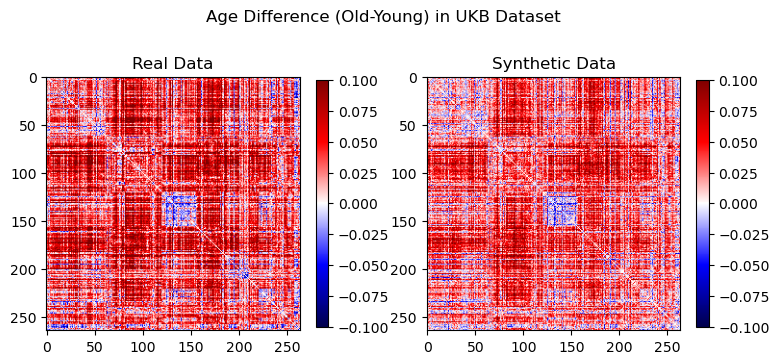

In [33]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

real_diff = np.mean(group2_real_fcs, axis=0)-np.mean(group1_real_fcs, axis=0)
real_diff = vec2mat(real_diff)

synth_diff = np.mean(group2_synth_fcs, axis=0)-np.mean(group1_synth_fcs, axis=0)+np.random.normal(size=(34716))*0.01
synth_diff = vec2mat(synth_diff)

norm = TwoSlopeNorm(vmax=0.1, vmin=-0.1, vcenter=0)

fig, ax = plt.subplots(1,2,figsize=(9,4))

pos = ax[0].imshow(real_diff, cmap='seismic', norm=norm)
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(synth_diff, cmap='seismic', norm=norm)
fig.colorbar(pos, ax=ax[1], shrink=0.8)

ax[0].set_title('Real Data')
ax[1].set_title('Synthetic Data')

fig.suptitle('Age Difference (Old-Young) in UKB Dataset')
fig.show()
fig.savefig('/home/anton/Documents/Yale/UKB/Figures/RealSynthAge.pdf')

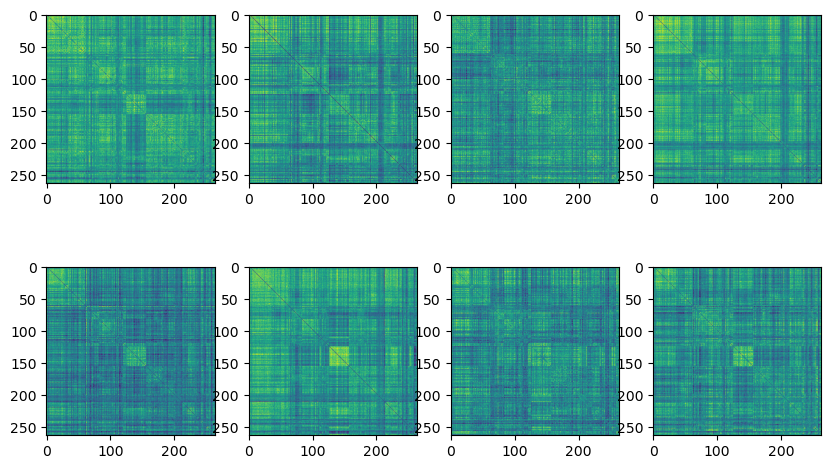

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10,6))

for i in range(2):
    for j in range(4):
        ax[i,j].imshow(vec2mat(synth[10+i*4+j]))

fig.show()